In [4]:
%matplotlib inline 

import time
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from SES_setup import * # Boilerplate code for single excitation subspace version of dimer model
from utils import * # Various helper functions
from style import * # Contains styling settings



SES_setup loaded globally


# The model

In this code we model a molecular system of the form:

<img src="PLOTS/PAPER/sys_schem.png" alt="Drawing" style="width: 650px;"/>

where there are two molecules (monomers), each with an independent vibrational environment, with parallel dipole moments, causing them to couple. The whole two-molecule (dimer) system is then embedded in an optical environment. The right figure shows the system in the eigenbasis of the Hamiltonian. The point of all this, is to investigate whether *dark-state protection* can exist in these systems (energy absorbed by sun gets trapped in $|\psi_-\rangle$ rather than reemitted), enabling them to [enhance photovoltaic power in organic solar cells](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.111.253601). 

The vibrational environments are treated non-perturbatively via the [collective coordinate master equation](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.90.032114), which maps the environments to two discrete modes, or collective coordinates (CC), and uses a Born-Markov master equation to describe the CC-residual bath interactions: 
<img src="PLOTS/PAPER/RC_mapping.png" alt="Drawing" style="width: 650px;"/>

The effect of the vibrations is included in the optical dissipator in a [*non-additive*](https://arxiv.org/abs/1812.04502) way.

Firstly, we set up some basic parameters and enforce a few symmetries using the `PARAMS_setup` function. This just makes the two vibrational environments symmetric ($T_1 = T_2$, etc), truncates the Hilbert space appropriately (CC oscillators are infinite) and includes any detuning ($\omega_1-\omega_2$) in the system Hamiltonian.

In [35]:
N =4 # Size of CC hilbert space - should be infinite but we truncate

w_0 = 30e-3*ev_to_inv_cm   # Peak center of Vibrational/phonon environment (Lorentzian)
Gamma = 30e-3*ev_to_inv_cm # Width of Lorentzian
T_ph = 300.                # Temperature of phonons
w_2 = 1.4*ev_to_inv_cm     # Energy of site 2
bias = 10e-3*ev_to_inv_cm  # Difference between site 1 and site 2 energies
V = 10e-3*ev_to_inv_cm     # Inter-site coupling
alpha = 8e-3*ev_to_inv_cm # Phonon coupling
T_EM = 6000.               # Photon temperature (~black-body temperature of the sun)
alpha_EM = 5.309e-3        # molecule-photon coupling strength 


PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=alpha,
                      T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)

Now we build the Hamiltonians and master equations. `L` is a dictionary containing the additive and non-additive versions of the model.


In [36]:
H, L, PARAMS = get_H_and_L(PARAMS,silent=False, threshold=1e-7)


****************************************************************
The operators took 1.43907904625 and have dimension 39.
Building the RC Liouvillian took 1.539 seconds.
It is 1521by1521. The full basis would be 2304by2304
Full optical Liouvillian took 0.967586994171 seconds.
Full optical Liouvillian took 0.774498939514 seconds.
Chopping reduced the sparsity from 10.104% to 8.759%


In [37]:
energies_dict, states_dict, phonon_occ_dict = separate_states(H[1], PARAMS, trunc=0.8)
assert(energies_dict['ground'][0] == 0.0) # Check that the ground-state energy is zero


In [42]:
ops = make_expectation_operators(PARAMS)
print("could calculate:")
print(ops.keys())
timelist = np.linspace(0, 100, 2000)                            # List of time values for dynamics 
rho_0 = states_dict['ground'][0]*states_dict['ground'][0].dag() # Start system in ground state
e_ops = [ops['dark'], ops['XO']]                                # List of expectation values to calculate
dynamics = qt.mesolve(H[1], rho_0, timelist, c_ops=[L['nonadd']], e_ops=e_ops, progress_bar=True)

could calculate:
['OO', 'sigma_z', 'sigma_y', 'sigma_x', 'XO', 'RC2_number', 'eig_x_equiv', 'dark', 'bright', 'RC1_number', 'RC2_position', 'OX', 'site_coherence', 'RC1_position1', 'eig_y', 'eig_x', 'eig_z']
10.0%. Run time:  29.32s. Est. time left: 00:00:04:23
20.0%. Run time:  59.29s. Est. time left: 00:00:03:57
30.0%. Run time:  90.45s. Est. time left: 00:00:03:31
40.0%. Run time: 126.69s. Est. time left: 00:00:03:10
50.0%. Run time: 158.09s. Est. time left: 00:00:02:38
60.0%. Run time: 187.75s. Est. time left: 00:00:02:05
70.0%. Run time: 216.54s. Est. time left: 00:00:01:32
80.0%. Run time: 245.26s. Est. time left: 00:00:01:01
90.0%. Run time: 274.04s. Est. time left: 00:00:00:30
Total run time: 302.76s


In [43]:
steady = qt.steadystate(H[1], [L['nonadd']]) # Steadystate density matrix

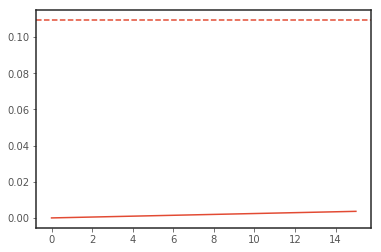

In [41]:
plt.plot(timelist, dynamics.expect[0])
plt.axhline((steady*ops['dark']).tr().real, linestyle='dashed')

**Now lets increase phonon coupling and see if the dark-state population increases or decreases**

In [44]:
alpha = 10e-3*ev_to_inv_cm # Phonon coupling
PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=alpha,
                      T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
H, L, PARAMS = get_H_and_L(PARAMS,silent=False, threshold=1e-7)
dynamics_stronger = qt.mesolve(H[1], rho_0, timelist, 
                               c_ops=[L['nonadd']], e_ops=e_ops, progress_bar=True)
steady_stronger = qt.steadystate(H[1], [L['nonadd']]) # Steadystate density matrix


****************************************************************
The operators took 1.32873892784 and have dimension 39.
Building the RC Liouvillian took 1.415 seconds.
It is 1521by1521. The full basis would be 2304by2304
Full optical Liouvillian took 0.973632097244 seconds.
Full optical Liouvillian took 0.736009120941 seconds.
Chopping reduced the sparsity from 10.137% to 8.759%
10.0%. Run time:  29.45s. Est. time left: 00:00:04:25
20.0%. Run time:  58.41s. Est. time left: 00:00:03:53
30.0%. Run time:  87.53s. Est. time left: 00:00:03:24
40.0%. Run time: 116.58s. Est. time left: 00:00:02:54
50.0%. Run time: 145.52s. Est. time left: 00:00:02:25
60.0%. Run time: 174.56s. Est. time left: 00:00:01:56
70.0%. Run time: 203.71s. Est. time left: 00:00:01:27
80.0%. Run time: 232.87s. Est. time left: 00:00:00:58
90.0%. Run time: 262.01s. Est. time left: 00:00:00:29
Total run time: 290.79s


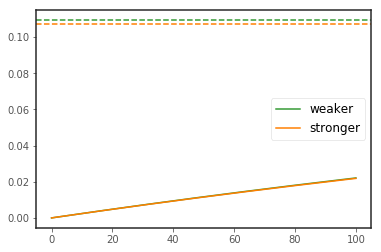

In [46]:
plt.plot(timelist, dynamics.expect[0], color=colourWheel[0], label='weaker')
plt.plot(timelist, dynamics_stronger.expect[0], color=colourWheel[7], label='stronger')

plt.axhline((steady*ops['dark']).tr().real, linestyle='dashed', color=colourWheel[0])
plt.axhline((steady_stronger*ops['dark']).tr().real, linestyle='dashed', color=colourWheel[7])
plt.legend()

In this case, stronger phonon coupling does not increase steadystate dark-state population.